# Plots of Radar Reflectivity and MSG SEVIRI Brightness Temperatures for Cases

An overview plot for the four case days is created.

In [1]:
%matplotlib inline

import os, sys, glob
import pylab as pl
pl.rcParams['font.size'] = 16.0


#pl.matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

import numpy as np
import datetime
import io_tools.netcdf as ncio

from plotting_tools.bmaps import make_map, Basemap
from plotting_tools.colormaps import nice_cmaps, enhanced_colormap
from standard_config import *

## Set Configuration

The dates / times for the different case day plots will be prescribed:

In [2]:
dates = ['20140729_1400', '20140815_1400', '20150704_1900', '20150705_1600']

expnames = ['default-redone_v2', 'default', 'shifted-double_day', 'shifted']

modes = ['msevi', 'synsat1', 'synsat2', 'synsat3']
rmodes = ['rado-DOM', 'radvop-DOM01', 'radvop-DOM02', 'radvop-DOM03']

nplots = 2   
# nplots = 4

## Data Reader Functions

### Brightness Temperature

In [3]:
def read_bt(time_stamp, mode = 'msevi', expname = 'default'):
    '''
    Reads brightness temperatures of obs and ICON simulations.
    '''
    
    # time arthimetics
    date, time = time_stamp.split('_')
    time_obj = datetime.datetime.strptime(time_stamp, '%Y%m%d_%H%M')
    
    date_frac = np.float(date) + (60. * time_obj.hour + time_obj.minute ) /( 60.* 24)

    
    # create filename
    # ================

    # set input data path
    fdir = '/work/bm0974/cai_S5/data/synsat'
    
    # set filename
    fname = '%s/%s_3d_coarse_icon-lem-tstack_*_%s-%s.nc' % (fdir, mode, date, expname)
    fname = glob.glob( fname )[0]
    
    print '... reading from ', fname
    
    # select the right time index
    time = ncio.read_icon_4d_data(fname, 'time', itime = None)['time']
    time_index, = np.where( np.array(time) == date_frac )
    
    
    # and read bt108 field
    vname = 'bt108'
    d = ncio.read_icon_4d_data(fname, vname, itime = time_index)[vname]
    
    return d.squeeze()

b = read_bt(dates[1])

... reading from  /work/bm0974/cai_S5/data/synsat/msevi_3d_coarse_icon-lem-tstack_DOM_20140815-default.nc


/pf/b/b380352/lib/tropy/io_tools/netcdf.py:275: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if itime == None:


### Radar Reflectivity

In [4]:
def read_rx(time_stamp, mode = 'radvop-DOM01', expname = 'default'):
    
    '''
    Reads radar reflectivities. 
    '''
    
    # time arthimetics
    date, time = time_stamp.split('_')
    time_obj = datetime.datetime.strptime(time_stamp, '%Y%m%d_%H%M')
    
    # split up mode
    mtype, domain = mode.split('-')
    
    # create filename
    # ================
    
    # set input data path
    if mtype == 'radvop':
        fdir = '/work/bm0974/cai_S5/data/radvop'

        # set filename
        fname = '%s/dbz-mie_%s_%s_ICON-grid_628x530.nc' % (fdir, domain, date)
    #fname = glob.glob( fname )[0]
    elif mtype == 'rado':
        fdir = '/work/bm0974/cai_S5/data/radolan'

        # set filename
        fname = '%s/hdfd_miub_drnet00_l3_dbz_rr_v00_%s-dwd_ICON-grid_628x530.nc' % (fdir, date)
        
    
    
    print '... reading from ', fname
    
    # select the right time index
    seconds_since = ncio.read_icon_4d_data(fname, 'time', itime = None)['time']
    t0 = datetime.datetime(1970, 1, 1)
    tvec = []
    for s in seconds_since:
        tvec.append( t0 + datetime.timedelta(seconds = s) )
    
    
    time_index, = np.where( np.array(tvec) == time_obj )
    
    # and read bt108 field
    vname = 'dbz'
    d = ncio.read_icon_4d_data(fname, vname, itime = time_index)[vname]
    
    return np.ma.masked_greater( d.squeeze(), 90 )

b = read_rx(dates[1])

... reading from  /work/bm0974/cai_S5/data/radvop/dbz-mie_DOM01_20140815_ICON-grid_628x530.nc


## Data Input

### Georefence

In [5]:
gname = '/work/bm0974/cai_S5/data/synsat/msevi_3d_coarse_icon-lem-tstack_DOM_20140815-default.nc'
geo = ncio.read_icon_4d_data(gname, ['lon', 'lat'], itime = None)

lon, lat = geo['lon'], geo['lat']

### Brightness Temperatures

In [6]:
bts = {}
for mode in modes:
    for i, time_stamp in enumerate(dates):
        
        key = '%s-%s' % (mode, time_stamp)
        bts[key] = read_bt(time_stamp, mode = mode, expname = expnames[i])

... reading from  /work/bm0974/cai_S5/data/synsat/msevi_3d_coarse_icon-lem-tstack_DOM_20140729-default-redone_v2.nc
... reading from  /work/bm0974/cai_S5/data/synsat/msevi_3d_coarse_icon-lem-tstack_DOM_20140815-default.nc
... reading from  /work/bm0974/cai_S5/data/synsat/msevi_3d_coarse_icon-lem-tstack_DOM_20150704-shifted-double_day.nc
... reading from  /work/bm0974/cai_S5/data/synsat/msevi_3d_coarse_icon-lem-tstack_DOM_20150705-shifted.nc
... reading from  /work/bm0974/cai_S5/data/synsat/synsat1_3d_coarse_icon-lem-tstack_DOM01_20140729-default-redone_v2.nc
... reading from  /work/bm0974/cai_S5/data/synsat/synsat1_3d_coarse_icon-lem-tstack_DOM01_20140815-default.nc
... reading from  /work/bm0974/cai_S5/data/synsat/synsat1_3d_coarse_icon-lem-tstack_DOM01_20150704-shifted-double_day.nc
... reading from  /work/bm0974/cai_S5/data/synsat/synsat1_3d_coarse_icon-lem-tstack_DOM01_20150705-shifted.nc
... reading from  /work/bm0974/cai_S5/data/synsat/synsat2_3d_coarse_icon-lem-tstack_DOM02_2014

### Radar Reflectivities

In [7]:
rxs = {}
for mode in rmodes:
    for i, time_stamp in enumerate(dates):
        
        key = '%s-%s' % (mode, time_stamp)
        rxs[key] = read_rx(time_stamp, mode = mode, expname = expnames[i])

... reading from  /work/bm0974/cai_S5/data/radolan/hdfd_miub_drnet00_l3_dbz_rr_v00_20140729-dwd_ICON-grid_628x530.nc
... reading from  /work/bm0974/cai_S5/data/radolan/hdfd_miub_drnet00_l3_dbz_rr_v00_20140815-dwd_ICON-grid_628x530.nc
... reading from  /work/bm0974/cai_S5/data/radolan/hdfd_miub_drnet00_l3_dbz_rr_v00_20150704-dwd_ICON-grid_628x530.nc
... reading from  /work/bm0974/cai_S5/data/radolan/hdfd_miub_drnet00_l3_dbz_rr_v00_20150705-dwd_ICON-grid_628x530.nc
... reading from  /work/bm0974/cai_S5/data/radvop/dbz-mie_DOM01_20140729_ICON-grid_628x530.nc
... reading from  /work/bm0974/cai_S5/data/radvop/dbz-mie_DOM01_20140815_ICON-grid_628x530.nc
... reading from  /work/bm0974/cai_S5/data/radvop/dbz-mie_DOM01_20150704_ICON-grid_628x530.nc
... reading from  /work/bm0974/cai_S5/data/radvop/dbz-mie_DOM01_20150705_ICON-grid_628x530.nc
... reading from  /work/bm0974/cai_S5/data/radvop/dbz-mie_DOM02_20140729_ICON-grid_628x530.nc
... reading from  /work/bm0974/cai_S5/data/radvop/dbz-mie_DOM0

## Plot Field Comparison

### set a map

In [8]:
kws = dict( llcrnrlon = lon.min(), llcrnrlat = lat.min(), 
            urcrnrlon = lon.max(), urcrnrlat = lat.max() )

mp = Basemap(projection = 'cyl', resolution = 'i', **kws)
x,y = mp(lon, lat)
pl.close()

### SEVIRI Brightness Temperature

In [24]:
import matplotlib.colors as mcol
def enhanced_colormap(vmin = 200., vmed = 240., vmax = 300.):

    
    nfull = 256

    ngray = int( nfull * (vmax - vmed) / (vmax - vmin) )
    ncol = nfull - ngray

    colors1 = pl.cm.gray_r(np.linspace(0., 1., ngray))
    # colors2 = pl.cm.jet_r(np.linspace(0, 1., ncol))
    colors2 = pl.cm.viridis_r(np.linspace(0, 1., ncol))#**0.3)

    # combine them and build a new colormap
    colors = np.vstack((colors2, colors1))
    mymap = mcol.LinearSegmentedColormap.from_list('enhanced_colormap', colors)


    return mymap

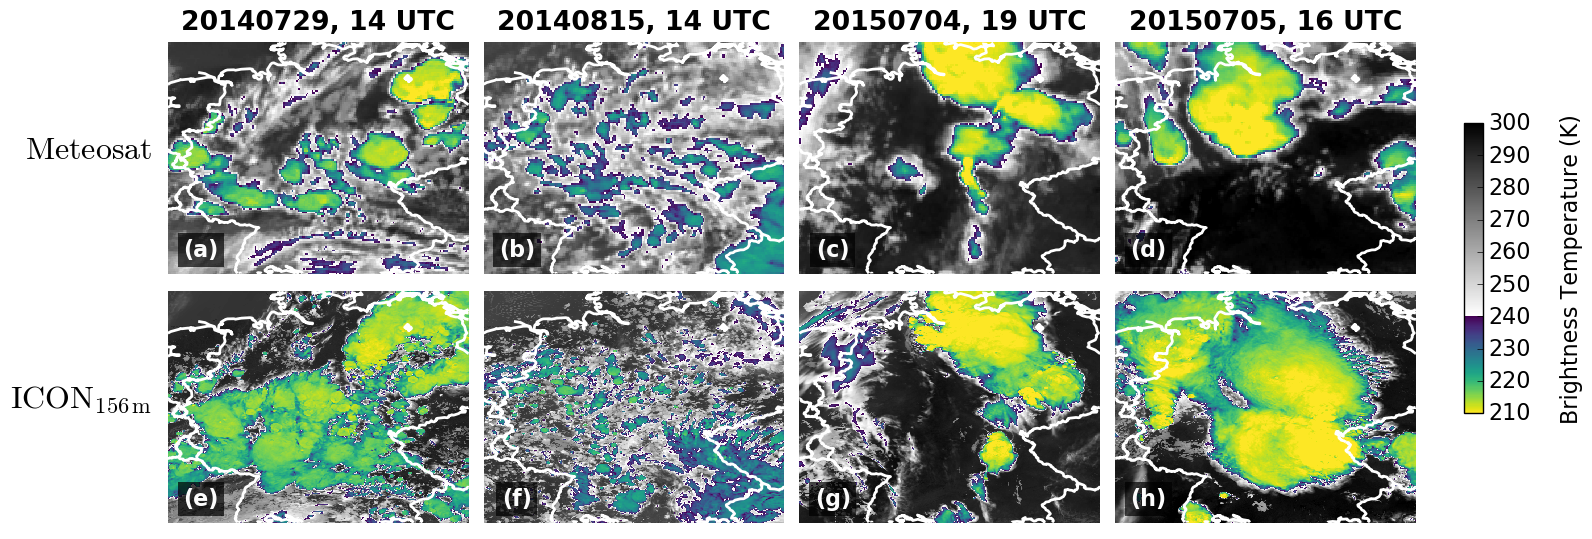

In [25]:
alpha = list(map(chr, range(97, 123)))
n = 0

cmap = enhanced_colormap(vmin = 210, vmed = 240, vmax = 300)

fig, axs = pl.subplots(nrows = nplots, ncols = 4, sharex = True, sharey = True, figsize = (16, 2.9*nplots))
#axs = axs.flatten()

labels = [r'$\mathrm{Meteosat}$',  r'$\mathrm{ICON_{156\,m}}$', 
          r'$\mathrm{ICON_{312\,m}}$', r'$\mathrm{ICON_{625\,m}}$' ]

for i, mode in enumerate(modes[:nplots]):
    for j, date in enumerate(dates):

   
        key = '%s-%s' % (mode, date)
    

        pl.sca(axs[i, j])
        axs[i,j].axis('off')
        if i == 0:
            tilab = date.replace('_', ', ').replace('00', ' UTC')
            pl.title(tilab, fontsize = 'large', fontweight = 'bold')
    
        mp.drawcountries(color = 'white', linewidth = 2)
        mp.drawcoastlines(color = 'white', linewidth = 2)
        
        

        pcm = mp.pcolormesh(x,y, bts[key], cmap = cmap, vmin = 210, vmax = 300)
    
        xt, yt = mp( 6.5, 48.3 )
        pl.text(xt, yt, '(%s)' % alpha[n], color = 'white', fontweight = 'bold', ha = 'center', va = 'center',
                           bbox = dict(facecolor='black', alpha=0.7, edgecolor = 'None'))
#        pl.text(xt, yt, '(%s)' % alpha[n], color = 'black', fontweight = 'bold', ha = 'center', va = 'center',
#                           bbox = dict(facecolor='white', alpha=0.7, edgecolor = 'None'))
    
        n += 1

        
fig = pl.gcf()
pl.subplots_adjust(left = 0.1, right = 0.88, hspace = 0.02, wspace = 0.05, bottom = 0.05)


for n in range(nplots):
    a = axs[n][0]
    apos = a.get_position()
    pl.figtext(apos.x0 - 0.01, apos.y0 + apos.height / 2., labels[n],
                           ha = 'right', fontsize = 'x-large')


cax = fig.add_axes([0.91, 0.25, 0.012, 0.5])
cbar = pl.colorbar(pcm, cax)
pl.figtext(0.97, 0.5, 'Brightness Temperature (K)',
               va = 'center', rotation=90)

pl.savefig('/work/bm0974/cai_S5/pics/paper_bt-overview-nplot%d.png' % nplots, dpi = 300)

### Radar Reflectivities

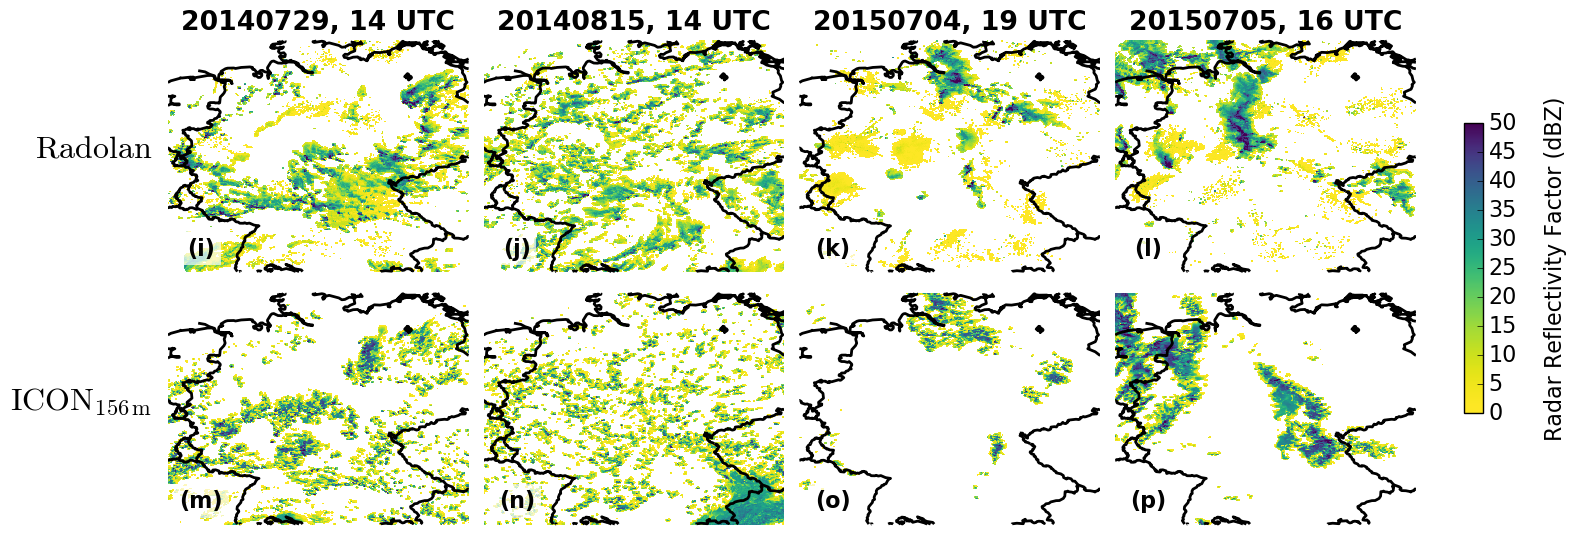

In [34]:
cmap = nice_cmaps('white-green-orange')

colors = pl.cm.viridis_r(np.linspace(0,1,40)**1.6)
cmap = mcol.LinearSegmentedColormap.from_list('enhanced_colormap', colors)

labels = [r'$\mathrm{Radolan}$',  r'$\mathrm{ICON_{156\,m}}$', 
          r'$\mathrm{ICON_{312\,m}}$', r'$\mathrm{ICON_{625\,m}}$' ]

fig, axs = pl.subplots(nrows = nplots, ncols = 4, sharex = True, sharey = True, figsize = (16,2.9*nplots))
#axs = axs.flatten()
n = 8

for i, mode in enumerate(rmodes[:nplots]):
    for j, date in enumerate(dates):

   
        key = '%s-%s' % (mode, date)
    

        pl.sca(axs[i, j])
        axs[i,j].axis('off')
        
        if i == 0:
            tilab = date.replace('_', ', ').replace('00', ' UTC')

            pl.title(tilab, fontsize = 'large', fontweight = 'bold')
    
        mp.drawcountries(color = 'black', linewidth = 2)
        mp.drawcoastlines(color = 'black', linewidth = 2)
                

        pcm = mp.pcolormesh(x,y, np.ma.masked_less( rxs[key], 0),  cmap = cmap, vmin = 0, vmax = 50)

        xt, yt = mp( 6.5, 48.3 )
        pl.text(xt, yt, '(%s)' % alpha[n], color = 'black', fontweight = 'bold', ha = 'center', va = 'center',
                           bbox = dict(facecolor='white', alpha=0.7, edgecolor = 'None'))
    
        n += 1
        
fig = pl.gcf()
pl.subplots_adjust(left = 0.1, right = 0.88, hspace = 0.05, wspace = 0.05, bottom = 0.05)

for n in range(nplots):
    a = axs[n][0]

    apos = a.get_position()
    pl.figtext(apos.x0 - 0.01, apos.y0 + apos.height / 2., labels[n],
                           ha = 'right', fontsize = 'x-large')


cax = fig.add_axes([0.91, 0.25, 0.012, 0.5])
cbar = pl.colorbar(pcm, cax)
pl.figtext(0.96, 0.5, 'Radar Reflectivity Factor (dBZ)',
               va = 'center', rotation=90)

pl.savefig('/work/bm0974/cai_S5/pics/paper_rx-overview-nplot%d.png' % nplots, dpi = 300)

In [ ]:
cmap = pl.cm.viridis_r

In [ ]:
pl.cm.vis